In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''

In [5]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
class_names = ['Circlar Alopecia','Flees','Healthy','Runglong','Skin Lesions']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [6]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/test'

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [11]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4270 | train_acc: 0.8634 | test_loss: 0.4048 | test_acc: 0.8698
Epoch: 2 | train_loss: 0.1548 | train_acc: 0.9641 | test_loss: 0.2967 | test_acc: 0.8958
Epoch: 3 | train_loss: 0.1017 | train_acc: 0.9788 | test_loss: 0.2447 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.0750 | train_acc: 0.9860 | test_loss: 0.2182 | test_acc: 0.9323
Epoch: 5 | train_loss: 0.0587 | train_acc: 0.9903 | test_loss: 0.2000 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.0478 | train_acc: 0.9926 | test_loss: 0.1918 | test_acc: 0.9505
Epoch: 7 | train_loss: 0.0400 | train_acc: 0.9946 | test_loss: 0.1904 | test_acc: 0.9453
Epoch: 8 | train_loss: 0.0335 | train_acc: 0.9965 | test_loss: 0.1840 | test_acc: 0.9453
Epoch: 9 | train_loss: 0.0295 | train_acc: 0.9956 | test_loss: 0.1825 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.0248 | train_acc: 0.9979 | test_loss: 0.1800 | test_acc: 0.9531


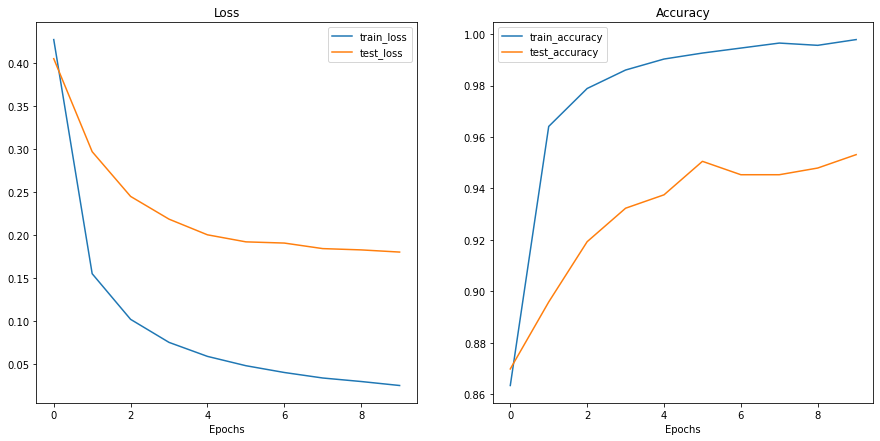

In [12]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

Class: circlar alopecia
Precision: 0.9347826086956522
Recall: 1.0
F1 Score: 0.9662921348314606

Class: flees
Precision: 1.0
Recall: 0.6875
F1 Score: 0.8148148148148148

Class: healthy
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1 Score: 0.7692307692307692

Class: runglong
Precision: 0.961038961038961
Recall: 0.9426751592356688
F1 Score: 0.9517684887459807

Class: skin lesions
Precision: 0.9619047619047619
Recall: 1.0
F1 Score: 0.9805825242718447



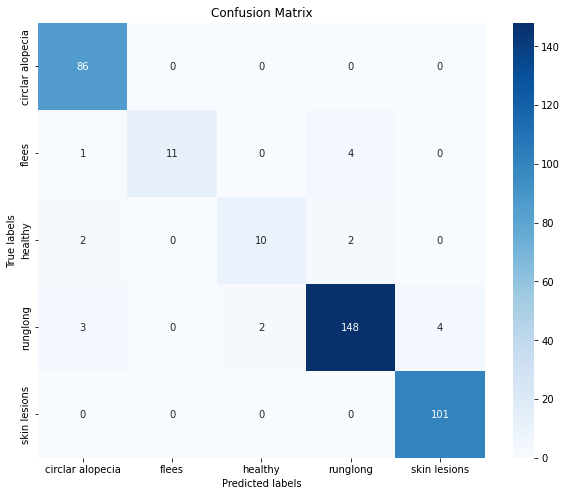

In [13]:

def calculate_metrics(model, test_dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return precision, recall, f1, cm

precision, recall, f1, confusion_matrix = calculate_metrics(pretrained_vit, test_dataloader_pretrained, device)

for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


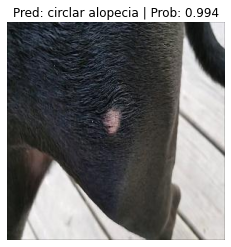

In [15]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/Skin Datasets/validate/circlar alopecia/circular_alopecia_00000023_jpg.rf.8df4f9d422595e065d5687927d61f94f.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

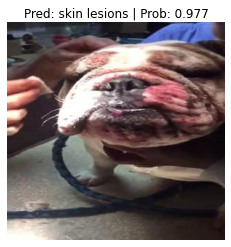

In [16]:
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/Skin Datasets/validate/skin lesions/skin_lesions_00000120_jpg.rf.3670734b093e392b239870b5ab86c5fd.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [15]:
model_save_path = "pretrained_vit_eye_final.pth"
torch.save(pretrained_vit, model_save_path)

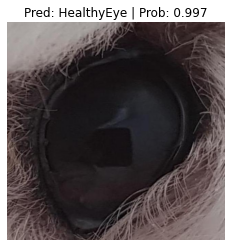

In [19]:
import requests
import torch
from going_modular.going_modular.predictions import pred_and_plot_image

class_names = ['Circlar Alopecia','Flees','Healthy','Runglong','Skin Lesions']

saved_model_path = "/Users/chamidiperera/Downloads/Datasets/ViT/pretrained_vit_eye_final.pth"
pretrained_vit = torch.load(saved_model_path)

# Setup custom image path
custom_image_path = "/Users/chamidiperera/Downloads/Datasets/valid/healthy/D19_2ab64e33-60a5-11ec-8402-0a7404972c70_jpg.rf.ce98692b7e74aba98af231e030b11580.jpg"
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
